#Global

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [10]:
import bz2
import json

In [11]:
quotes = bz2.open('/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2', 'rb')

In [12]:
samples = 0
quote=""
for q in quotes:
  if samples==1:
    break
  quote = json.loads(q)
  print(quote)
  samples += 1

{'quoteID': '2020-01-28-000082', 'quotation': '[ D ] espite the efforts of the partners to create a non-political award that unites the Jewish people, some have incorrectly interpreted the participation of the Office of the Prime Minister in the Genesis Prize as bringing a political dimension to this important initiative,', 'speaker': 'None', 'qids': [], 'date': '2020-01-28 08:04:05', 'numOccurrences': 1, 'probas': [['None', '0.7272'], ['Prime Minister Netanyahu', '0.2445'], ['Natan Sharansky', '0.0283']], 'urls': ['http://israelnationalnews.com/News/News.aspx/275210'], 'phase': 'E'}


In [13]:
quote

{'date': '2020-01-28 08:04:05',
 'numOccurrences': 1,
 'phase': 'E',
 'probas': [['None', '0.7272'],
  ['Prime Minister Netanyahu', '0.2445'],
  ['Natan Sharansky', '0.0283']],
 'qids': [],
 'quotation': '[ D ] espite the efforts of the partners to create a non-political award that unites the Jewish people, some have incorrectly interpreted the participation of the Office of the Prime Minister in the Genesis Prize as bringing a political dimension to this important initiative,',
 'quoteID': '2020-01-28-000082',
 'speaker': 'None',
 'urls': ['http://israelnationalnews.com/News/News.aspx/275210']}

In [14]:
import pandas as pd
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet')

In [15]:
speaker_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [16]:
label_description = pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [17]:
label_description.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


In [18]:
label_description.loc['Q31']['Label']

'Belgium'

In [20]:
!pip install tld

     |████████████████████████████████| 412 kB 5.2 MB/s 


# Dealing with the features

For the questions we want to use, we don't need all the features. We decided to keep the following ones:


*   **date**: To be able to work with them.
*   **numOccurences**: To take out the duplicates.
*   **qids**: The speakers' id, necessary to connect with the speaker_attributes.
*   **quotation**: To be able to assess its positivity.
*   **quoteID**: To identify them.
*   **speaker**: To access their attributes and see if there's multiple qids for the same speaker.

For the 3 remaining features, we explain why we choosed to take them out:




#### phase

As we see on the [description of the phase](https://github.com/epfl-dlab/Quotebank/blob/main/phases.md). All of quotations we will use (2015-2020) are from phase E as they are past June 2014. We check below:

In [27]:
count_E = 0

with bz2.open(path_to_file, 'rb') as s_file:
  for instance in s_file:
    instance = json.loads(instance) # loading a sample
    phase = instance['phase'] # extracting list of links
    if phase == 'E':
      count_E += 1

In [30]:
print(f'We have {count_E*100/count_quote}% of quotes in phase E for 2020')

We have 100.0% of quotes in phase E for 2020


As expected, we don't have any other phase than phase 'E' in the dataset from 2020. We shouldn't have them for 2015-2019. With the test on 2020 and the description's informations, we decided that it safe to drop this feature.

#### probas

We only keep the main speaker, therefore the probabilities and name of the other speakers are not useful for us. We chose to rely on the decisions made by QuoteBanks in choosing the speaker, and only keep the main(s) one(s).

#### Urls

In our research, we don't specificaly look into the source of the quote, expect for the speaker. Therefore, we decided to drop the urls feature as it is irrevelant to our research.

###Dropping the unwanted features

We drop the unwanted features as explained before. We do this by keeping 

In [121]:
def drop_features(path_to_file, path_to_out, max_instances =-1):
  count = 0
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in s_file:
        if count == max_instances:
          return
        instance = json.loads(instance) # loading a sample
        series = pd.Series(instance)
        instance = series[['quoteID', 'date', 'numOccurrences', 'qids', 'quotation', 'speaker']].to_dict()
        d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
        count += 1

We try it with the 100 first instances:

In [122]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2'
path_to_out = '/content/quotes-2020-dropped-features.json.bz2'

drop_features(path_to_file, path_to_out, 100)

dropped_features_df = pd.read_json(path_to_out, compression='bz2', lines=True)
dropped_features_df.head()

,quoteID,date,numOccurrences,qids,quotation,speaker
0,2020-01-28-000082,2020-01-28 08:04:05,1,[],[ D ] espite the efforts of the partners to cr...,None
1,2020-01-16-000088,2020-01-16 12:00:13,1,[Q367796],[ Department of Homeland Security ] was livid ...,Sue Myrick
2,2020-02-10-000142,2020-02-10 23:45:54,1,[],... He (Madhav) also disclosed that the illega...,None
3,2020-02-15-000053,2020-02-15 14:12:51,2,[],"... [ I ] f it gets to the floor,",None
4,2020-01-24-000168,2020-01-24 20:37:09,4,[Q20684375],[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds


#Special case: when we need to have the speaker's information

For two of our questions, see the [readMe.md](https://), we want to access the speaker's attributes. If we don't have any informations concerning them, the quote becomes unseful for our research. 

In [24]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 

In [23]:
count_quote  = 0
count_none = 0
with bz2.open(path_to_file, 'rb') as s_file:
  for instance in s_file:
    instance = json.loads(instance) # loading a sample
    speaker = instance['speaker'] # extracting list of links
    count_quote +=1
    if speaker == 'None':
      count_none += 1
      
print(count_quote)
print(count_none)

5244449
1800844


In [31]:
print(f'We have {count_none*100/count_quote}% of None ')

We have 34.338097291059555% of None 


As we see, on the quotebank data of 2020 we already have ~34% of missing speaker, labelled as "None". Therefore, we remove them from all the informations and write them in a new Json file.

Why do we remove them? Because if we look at the exemple below, 

In [26]:
quote

{'date': '2020-01-28 08:04:05',
 'numOccurrences': 1,
 'phase': 'E',
 'probas': [['None', '0.7272'],
  ['Prime Minister Netanyahu', '0.2445'],
  ['Natan Sharansky', '0.0283']],
 'qids': [],
 'quotation': '[ D ] espite the efforts of the partners to create a non-political award that unites the Jewish people, some have incorrectly interpreted the participation of the Office of the Prime Minister in the Genesis Prize as bringing a political dimension to this important initiative,',
 'quoteID': '2020-01-28-000082',
 'speaker': 'None',
 'urls': ['http://israelnationalnews.com/News/News.aspx/275210']}

We see that, it is ~73% sure of not knowing who is the right speaker. We could take the as speaker the 

```
['Prime Minister Netanyahu', '0.2445']
```
We have more chance of it being false as it has only ~24% of chances of being him. We prefer to take only the speakers with an high chance of being right. We do it in the below method:


In [45]:
def drop_unknown_speaker(path_to_file, path_to_out, max_instances =-1):
  count = 0
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in s_file:
        if count == max_instances:
          return
        instance = json.loads(instance) # loading a sample
        speaker = instance['speaker']
        if speaker != 'None':
          d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
        count +=1

We check it with 100 000 instances (to fasten the test part):

In [56]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2'
path_to_out = '/content/quotes-2020-dropped_unknown_speaker.json.bz2'

drop_unknown_speaker(path_to_file, path_to_out, 100000)

dropped_unknown_speaker_df = pd.read_json(path_to_out, compression='bz2', lines=True)

print(dropped_unknown_speaker_df.loc[dropped_unknown_speaker_df.speaker == 'None', 'speaker'].count())

0


As we see, we can safely see that we take out all the 'None' speaker from the data.

#Data analysis

## Dates

As we are interested in dates, we want to understand their distributions.
As the dates are in the format 'yyyy-mm-dd hh:mm:ss', we check that all the dates are well in 2020 by checking the first 4 characters. Doing so helps us to check if there's any date which is not correctly written or missing:

In [64]:
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2'
count_2020 = 0

with bz2.open(path_to_file, 'rb') as s_file:
  for instance in s_file:
    instance = json.loads(instance) # loading a sample
    date = instance['date'] # extracting the date
    if date[:4] == '2020':
      count_2020 += 1

In [91]:
print(f'There is {count_2020*100/count_quote}% of date starting with 2020')

There is 100.0% of date starting with 2020


So it is as guessed.

To see the distribution of quotes per day of the year, we define a function to change the date format 'yyyy-mm-dd' into an index of a table. To do so we use the library date time.

In [105]:
from datetime import datetime

def get_day_of_year(date):
  date_time_obj = datetime.strptime(date[2:], '%y-%m-%d %H:%M:%S')
  d = date_time_obj.strftime("%-j")
  return d

In [116]:
print(get_day_of_year("2020-12-30 12:26:24"))

365


Now we can look at the distribution of the dates:

In [131]:
def count_per_day(path_to_file, max_instances=-1):
  count_days = np.zeros((366))
  count = 0
  with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
      if count == max_instances:
        break
      instance = json.loads(instance) # loading a sample
      date = instance['date'] # extracting the date
      idx = int(get_day_of_year(date))-1
      count_days[idx] +=1
      count+=1
    return count_days

We check for the different years with a sample of 100000 quotes to have a proper representation.

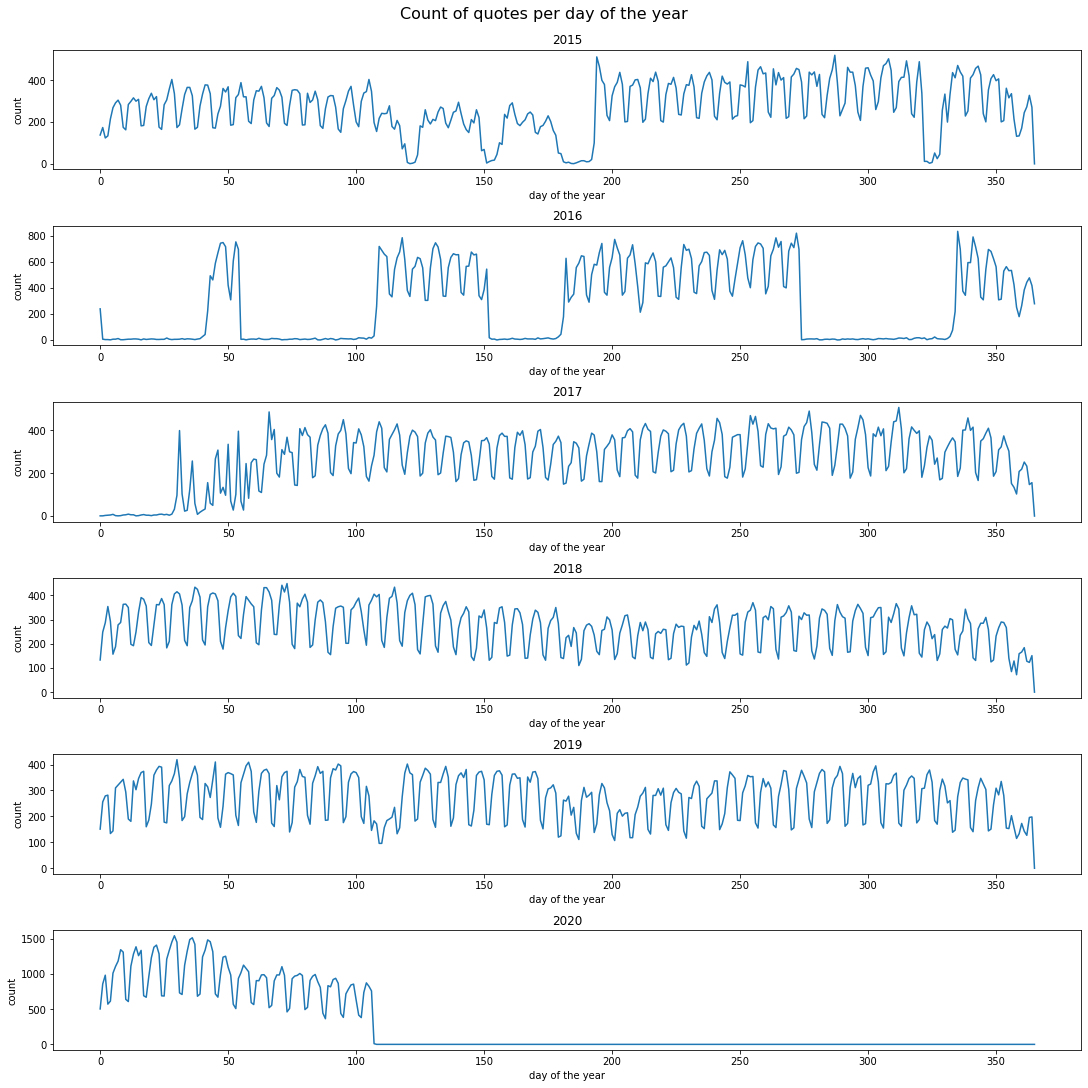

In [153]:
years = ['2015', '2016', '2017', '2018', '2019', '2020']
day = np.arange(366)

fig, axes = plt.subplots(6, constrained_layout=True,figsize=(15,15))
fig.suptitle('Count of quotes per day of the year', fontsize=16)


for year, ax in zip(years,axes):
  path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'.format(year=year)

  count_days = count_per_day(path_to_file, max_instances=100000)
  ax.plot(day, count_days)
  ax.set_title(year)
  ax.set_xlabel('day of the year')
  ax.set_ylabel('count')

plt.show()

Everytime we look at the dates, we have to be careful about the number of quotations per day. It could lead to wrong results if we want to look at the distribution of a type of quote over time. We see an evident weekly tendency and the quotes for the year 2020 stop at ~110 days. There's also some seemingly unexplicable drop in quotes.For example, the quotes from year 2016 do some strange time where the data is missing.